# DefDAP Advanced notebook

This notebook will outline usage of DefDAP, including loading a DIC and EBSD map, linking them with homologous points, producing maps, drawing line profiles and performing slip system analysis using grain inspector.

This notebook contains the dataset used in the following paper: https://www.sciencedirect.com/science/article/pii/S2589152919300444 which is available at this respository: https://data.mendeley.com/datasets/n4cdwp6pwc/1

### Load packages

In [38]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib qt

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap

from defdap import ebsd, hrdic
from defdap.plotting import HistPlot

### Load DIC data

In [ ]:
file_path = "../data/"

irrMap = hrdic.Map(file_path + "irr_003.txt")
irrMap.set_pattern("irr_8bin.jpg", 2)

nirrMap = hrdic.Map(file_path + "nirr_003.txt")
nirrMap.set_pattern("nirr_8bin.jpg", 2)

for Dic in [irrMap, nirrMap]:
    Dic.set_crop(left=0, right=0, top=0, bottom=0)
    Dic.set_scale((10/2048))

### Load EBSD data

In [ ]:
irrEbsd = ebsd.Map(file_path + "irr_new")
nirrEbsd = ebsd.Map(file_path + "nirr_new")

for Ebsd in [nirrEbsd, irrEbsd]:
    Ebsd.find_boundaries(3.6)
    Ebsd.find_grains(min_grain_size= 20)
    Ebsd.calc_average_grain_schmid_factors(load_vector=np.array([1, 0, 0]))
    Ebsd.calc_grain_mis_ori(calc_axis=True)

You can try to select your own homologous points using these functions, or you can use predefined ones in the following cell

In [ ]:
#irrMap.setHomogPoint(display='pattern')
#irrEbsd.setHomogPoint()

In [ ]:
irrMap.frame.homog_points = [(939, 170), (132, 220), (226, 860), (942, 864), (530, 430)]
nirrMap.frame.homog_points = [(98, 126), (99, 884), (880, 100), (555, 614), (483, 106), (936, 696)]
irrEbsd.frame.homog_points = [(407, 106), (85, 109), (112, 329), (392, 342), (240, 186)]
nirrEbsd.frame.homog_points = [(62, 60), (46, 339), (373, 69), (229, 250), (217, 59), (378, 295)]

### Link maps

In [ ]:
irrMap.link_ebsd_map(irrEbsd, transform_type='affine')
irrMap.find_grains(algorithm='warp');

nirrMap.link_ebsd_map(nirrEbsd, transform_type='affine')
nirrMap.find_grains(algorithm='warp');

### Draw a line profile

In [ ]:
nirrMap.draw_line_profile(vmax=0.2)

In [ ]:
irrMap.draw_line_profile(vmax=0.2)

### Stats

In [ ]:
irrMap.print_stats_table(percentiles=[0, 1, 5, 50, 95, 99, 100], components=['e','max_shear'])
nirrMap.print_stats_table(percentiles=[0, 1, 5, 50, 95, 99, 100], components=['e', 'max_shear'])

### Comparison plots

In [ ]:
# New colour map with red when saturated
viridis = cm.get_cmap('viridis', 512)
newcolors = viridis(np.linspace(0, 1, 512))
newcolors[-1:, :] = np.array([1, 0, 0, 1])
newcmp = ListedColormap(newcolors)

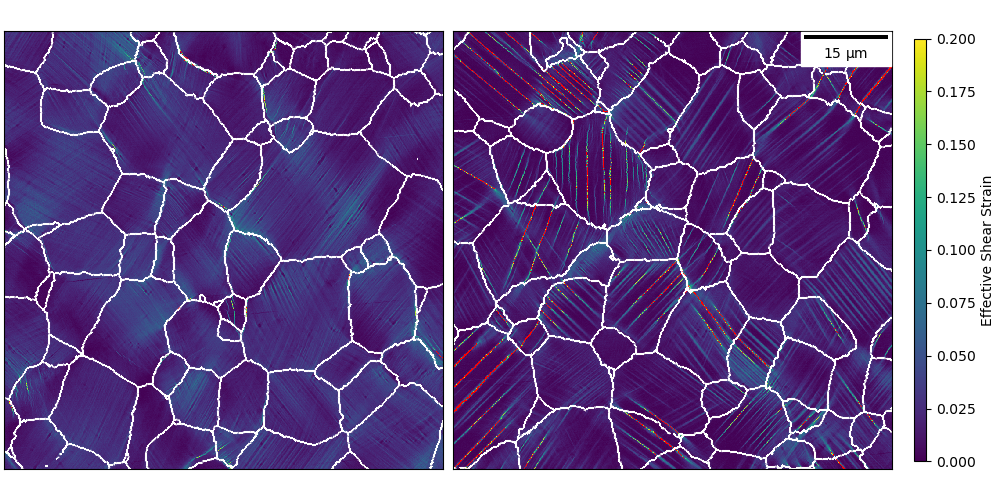

In [36]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5), constrained_layout=True)

plot0 = nirrMap.plot_map('max_shear', ax=ax1, fig=fig, plot_colour_bar=False,
                             vmin=0, vmax=0.2, cmap = newcmp, plot_gbs='line')
plot1 = irrMap.plot_map('max_shear', ax=ax2, fig=fig, plot_colour_bar=False, plot_scale_bar=True,
                             vmin=0, vmax=0.2, cmap = newcmp, plot_gbs='line')

plot1.add_colour_bar(label='Effective Shear Strain', aspect=35, shrink=0.86)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5), constrained_layout=True)

plot0 = nirrEbsd.plot_mis_ori_map(ax=ax1, fig=fig,component=3, 
                              plot_gbs='line', boundary_colour='black',
                              plot_colour_bar = False, cmap='coolwarm',
                              vmin=-4, vmax=4)
plot1 = irrEbsd.plot_mis_ori_map(ax=ax2, fig=fig, component=3, 
                               plot_gbs='line', boundary_colour='black',
                               plot_colour_bar=False, cmap='coolwarm',
                               vmin=-4, vmax=4)

plot1.add_colour_bar(label='Rotation about Z ($^\circ$)', aspect=35, shrink=0.86)

### Histogram

In [27]:
plot = HistPlot.create(
    irrMap.crop(irrMap.data['max_shear']) / np.nanmedian(irrMap.crop(irrMap.data['max_shear'])),
plot_type='step', axes_type="loglog", bins=200, range=(0.0001,100), label='Irradiated', alpha=0.6)

plot.add_hist(
    nirrMap.crop(nirrMap.data['max_shear']) / np.nanmedian(nirrMap.crop(nirrMap.data['max_shear'])), 
    bins=200, range=(0.0001,100), label = 'Unirradiated', alpha=0.6
    )

plot.add_legend()

plot.ax.set_xlabel("Effective shear strain (multiples of median)")
plot.ax.set_xlim(0.01, 50)
plot.ax.set_ylim(0.0001)

plt.axvline(1, color='black', linestyle='dashed', linewidth=1)

plt.tight_layout()

### Grain inspector

This will load a GUI tool used to inspect the slip in each grain. You can navigate between grains using the 'Previous Grain' and 'Next Grain' buttons in the top right. Click and drag within the grain to define slip lines and click the 'Save Line' button to the right to save and detect the active slip system.

In [31]:
irrMap.grain_inspector(vmax=0.1)

In [32]:
nirrMap.grain_inspector(vmax=0.1)

Finished finding grains (0:00:00) 


### Plot grains

After drawing lines on some grains above, this code will plot an IPF with the active slip system coloured.

In [ ]:
selMap = irrMap

prorilist = []; pyorilist=[]; baorilist=[]; multorilist = [];
for grain in selMap:
    for system in grain.groups_list:
        # If one slip system
        if len(system[2]) == 1:
            # If prismatic
            if system[2][0] in [1, 2, 3]:
                prorilist.append(grain.ref_ori)
            # If pyramidal
            if system[2][0] in [4, 5, 6, 7, 8, 9]:
                pyorilist.append(grain.ref_ori)
            #If basal
            if system[2][0] in [0]:
                pyorilist.append(grain.ref_ori)
        #If ambiguous
        if len(system[2]) >1:
            multorilist.append(grain.ref_ori)

f, ax = plt.subplots(figsize=(6,4))

markersize=40
    
quat.Quat.plot_ipf([grain.ref_ori for grain in selMap], [1,0,0], 'hexagonal', c='0.9', marker='o', s=markersize, ax=ax, label='no slip')  
if multorilist!=[]: quat.Quat.plot_ipf(multorilist, [1,0,0], 'hexagonal', c='0.6', marker='o', s=markersize, ax=ax, label='ambiguous')  
if prorilist!=[]: quat.Quat.plot_ipf(prorilist, [1,0,0], 'hexagonal', c='r', marker='o', s=markersize, ax=ax, label='prismatic')
if pyorilist!=[]: quat.Quat.plot_ipf(pyorilist, [1,0,0], 'hexagonal', c='g', marker='o', s=markersize, ax=ax, label='pyramidal')
if baorilist!=[]: quat.Quat.plot_ipf(baorilist, [1,0,0], 'hexagonal', c='b', marker='o', s=markersize, ax=ax, label='basal')

plt.legend(loc='upper left')